## Goals of notebook
1. Create nice visualizations of the LE data
2. Create figure template of a polar projection for:
    a. Unperturbed
    b. Perturbed
    c. Difference

how to accomplish that.... know what you want to plot, make a dataset of that data, import it and plot:
ie the data wrangling should be done elsewhere

here's template example: https://github.com/marbl-ecosys/cesm2-marbl/blob/master/notebooks/nutrient-plots.ipynb
this notebook isn't a template



In [8]:
# set up modules
%matplotlib inline
import os
import shutil

from glob import glob

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.colors as colors


import intake
import pop_tools

import util

In [24]:
pwd = os.getcwd()
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/figures'

## Spatial Variance

In [3]:
ds_djf_epoch = xr.open_zarr('data/cesm-le-fields-djf-epoch-mean.zarr')

In [4]:
#get difference between epochs
with xr.set_options(keep_attrs=True):  
    ds_djf_epoch_diff = ds_djf_epoch.diff('epoch').squeeze('epoch')
#ds_djf_epoch_diff

In [5]:
ds_djf_epoch

<xarray.Dataset>
Dimensions:    (epoch: 2, length: 3, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch      (epoch) <U9 '1920-1950' '2070-2100'
  * length     (length) float64 20.0 40.0 60.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * z_t        (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf   (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC      (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP        (epoch, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 17, 47, 160), meta=np.ndarray>
    SST        (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>

In [11]:
#for saving figures:
pwd = os.getcwd()
pwd
os.chdir('/glade/u/home/zephyrs/projects/krill-cesm-le/figures')
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/figures'

In [12]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [13]:
## Create Datafields to plot
kgp_mean = ds_djf_epoch['KGP'].mean('member_id')
sst_mean = ds_djf_epoch['SST'].mean('member_id')
chl_mean = ds_djf_epoch['Chl_surf'].mean('member_id')
ice_mean = ds_djf_epoch['IFRAC'].mean('member_id')

kgp_early = kgp_mean.sel(length='40').sel(epoch='1920-1950')
kgp_late = kgp_mean.sel(length='40').sel(epoch='2070-2100')
sst_early = sst_mean.sel(epoch='1920-1950')
sst_late = sst_mean.sel(epoch='2070-2100')
chl_early = chl_mean.sel(epoch='1920-1950')
chl_late = chl_mean.sel(epoch='2070-2100')
ice_early = ice_mean.sel(epoch='1920-1950')
ice_late = ice_mean.sel(epoch='2070-2100')


In [14]:
# Lat Lon Checks
lon = ds_djf_epoch.TLONG.values
lat = ds_djf_epoch.TLAT.values

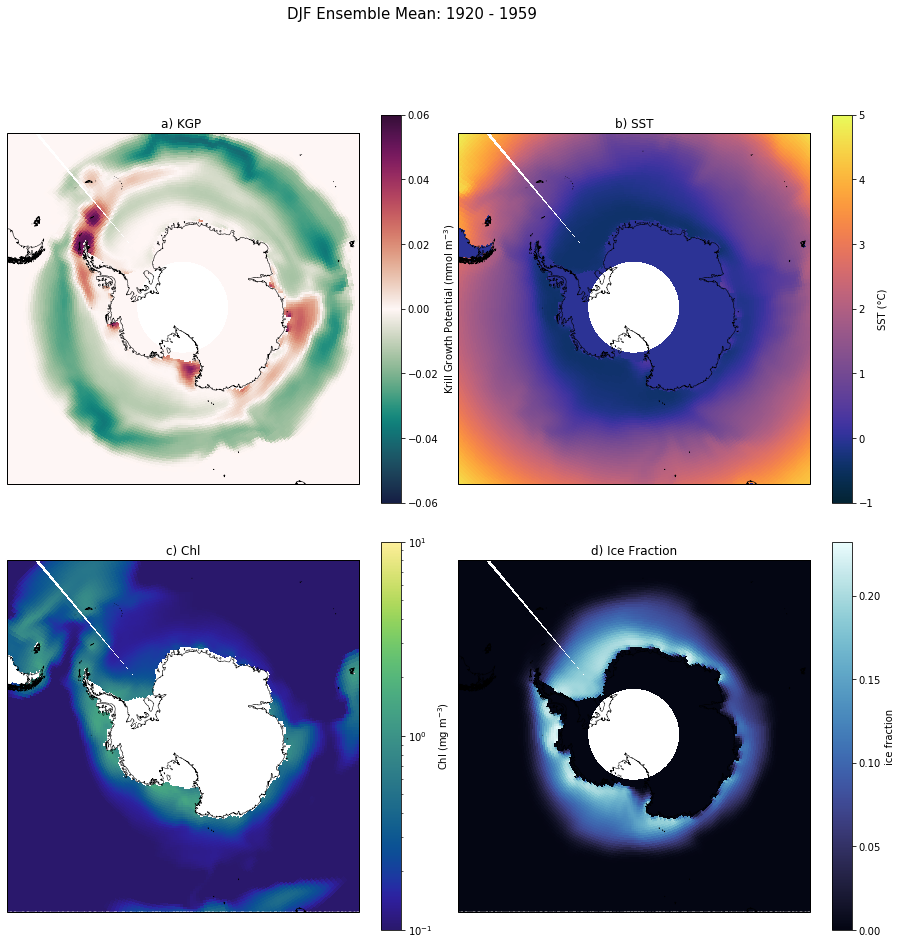

In [15]:

fig = plt.figure(figsize=(15,15))
fig.suptitle('DJF Ensemble Mean: 1920 - 1959', fontsize=15)

#---------- KGP
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) KGP ')

pc=ax.pcolormesh(lon, lat, kgp_early, cmap='cmo.curl',
                 vmin = -.06, vmax = .06,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Krill Growth Potential (mmol m$^{-3}$)')

#----------SST
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) SST')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, sst_early, cmap='cmo.thermal',
                 vmin = -1, vmax = 5,
                 transform=ccrs.PlateCarree())
cbar2 = fig.colorbar(pc, ax=ax,label='SST (°C)')

#----------Chl
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) Chl')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

norm = colors.LogNorm(vmin=0.1, vmax=10.)

pc=ax.pcolormesh(lon, lat, chl_early, cmap=cmocean.cm.haline,
                 norm=norm,
                 transform=ccrs.PlateCarree())
cbar3 = fig.colorbar(pc, ax=ax,label='Chl (mg m$^{-3}$)')

#----------IFRAC
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('d) Ice Fraction')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, ice_early, cmap=cmocean.cm.ice, transform=ccrs.PlateCarree())
cbar4 = fig.colorbar(pc, ax=ax,label='ice fraction')

fig.subplots_adjust(right=0.95,wspace=0.025, hspace=0.1)


fig.savefig('1920-1959', bbox_inches='tight') #,format='pdf');


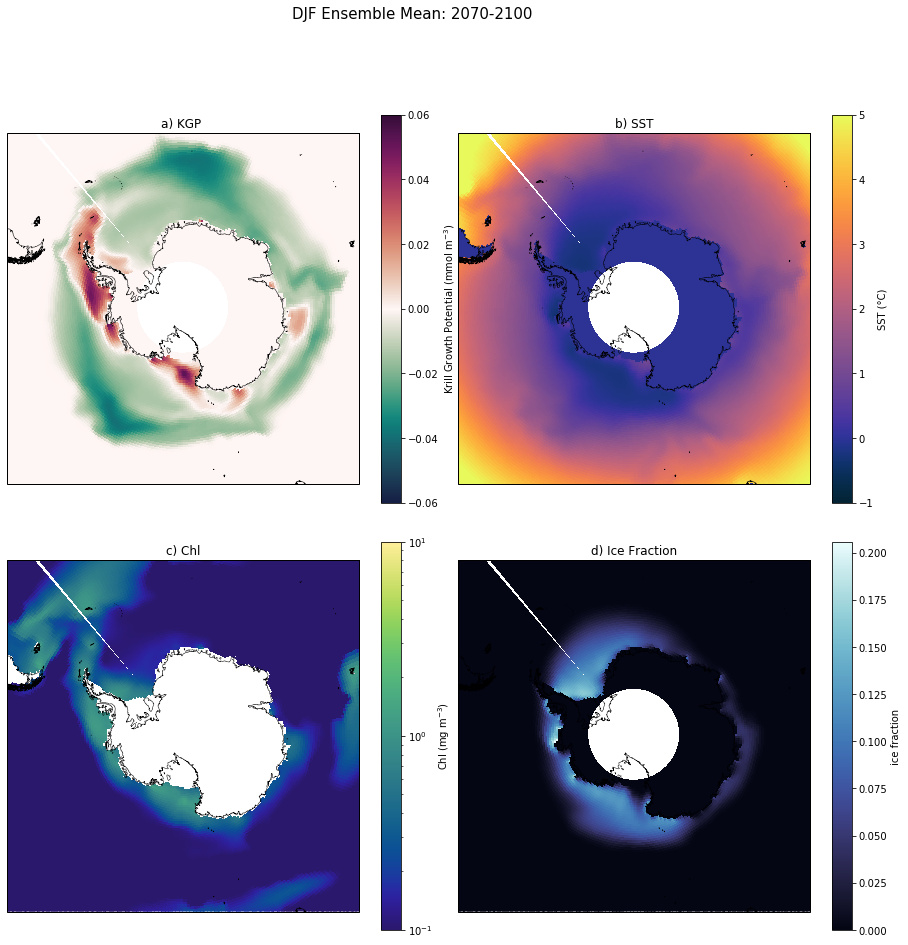

In [16]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('DJF Ensemble Mean: 2070-2100', fontsize=15)

#---------- KGP
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) KGP ')
pc=ax.pcolormesh(lon, lat, kgp_late, cmap='cmo.curl',
                 vmin = -.06, vmax = .06,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Krill Growth Potential (mmol m$^{-3}$)')


#----------SST
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) SST')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, sst_late, cmap='cmo.thermal',
                 vmin = -1, vmax = 5,
                 transform=ccrs.PlateCarree())
cbar2 = fig.colorbar(pc, ax=ax,label='SST (°C)')

#----------Chl
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) Chl')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

norm = colors.LogNorm(vmin=0.1, vmax=10.)

pc=ax.pcolormesh(lon, lat, chl_late, cmap=cmocean.cm.haline,
                 norm=norm,
                 transform=ccrs.PlateCarree())
cbar3 = fig.colorbar(pc, ax=ax,label='Chl (mg m$^{-3}$)')

#----------IFRAC
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('d) Ice Fraction')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, ice_late, cmap=cmocean.cm.ice, transform=ccrs.PlateCarree())
cbar4 = fig.colorbar(pc, ax=ax,label='ice fraction')

fig.subplots_adjust(right=0.95,wspace=0.025, hspace=0.1)

fig.savefig('2070-2100', bbox_inches='tight') #,format='pdf');


___
## Testing Other plot bits

In [17]:
ds_djf_epoch_diff

kgp_diff = ds_djf_epoch_diff['KGP'].mean('member_id').sel(length='40')
sst_diff = ds_djf_epoch_diff['SST'].mean('member_id')
chl_diff = ds_djf_epoch_diff['Chl_surf'].mean('member_id')
ice_diff = ds_djf_epoch_diff['IFRAC'].mean('member_id')


In [ ]:
kgp_diff

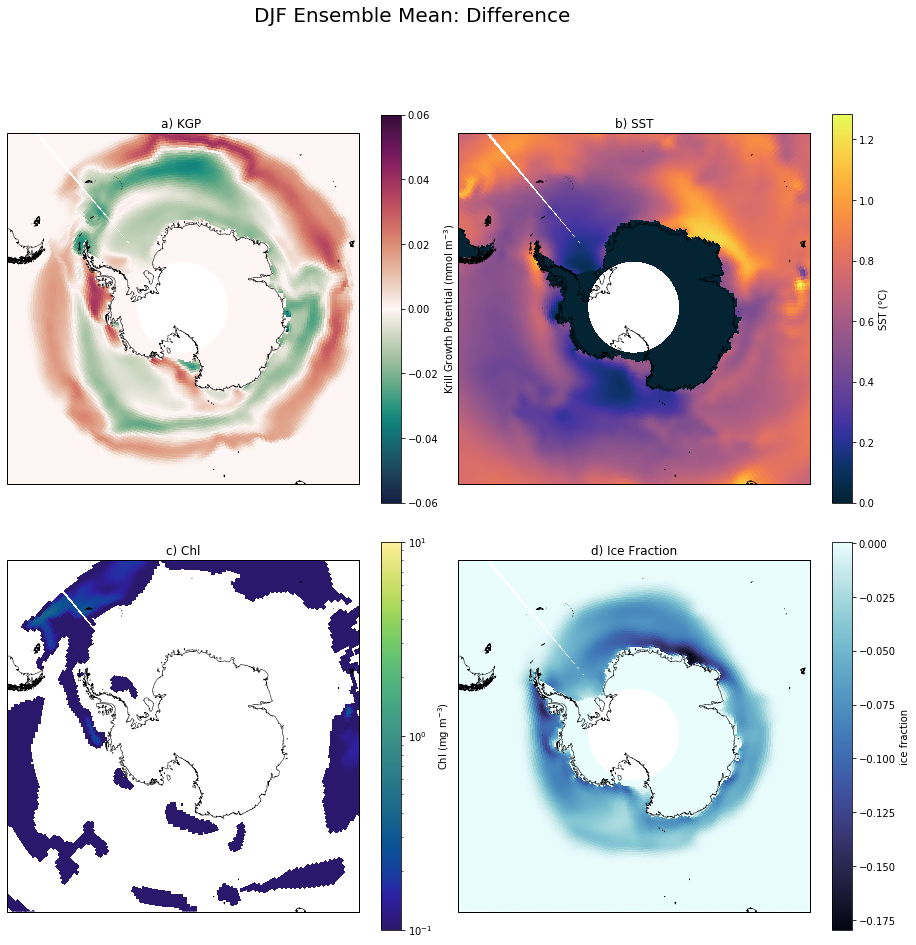

In [18]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(15,15))
fig.suptitle('DJF Ensemble Mean: Difference', fontsize=20)

#---------- KGP
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) KGP ')

pc=ax.pcolormesh(lon, lat, kgp_diff, cmap='cmo.curl',
                 vmin = -.06, vmax = .06,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Krill Growth Potential (mmol m$^{-3}$)')


#----------SST
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) SST')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, sst_diff, cmap='cmo.thermal',
                 transform=ccrs.PlateCarree())
cbar2 = fig.colorbar(pc, ax=ax,label='SST (°C)')

#----------Chl
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) Chl')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

norm = colors.LogNorm(vmin=0.1, vmax=10.)

pc=ax.pcolormesh(lon, lat, chl_diff, cmap=cmocean.cm.haline,
                 norm=norm,
                 transform=ccrs.PlateCarree())
cbar3 = fig.colorbar(pc, ax=ax,label='Chl (mg m$^{-3}$)')

#----------IFRAC
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('d) Ice Fraction')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, ice_diff, cmap=cmocean.cm.ice, transform=ccrs.PlateCarree())
cbar4 = fig.colorbar(pc, ax=ax,label='ice fraction')
fig.subplots_adjust(right=0.95,wspace=0.025, hspace=0.1)

fig.savefig('epoch-change-all4vars', bbox_inches='tight') #,format='pdf');


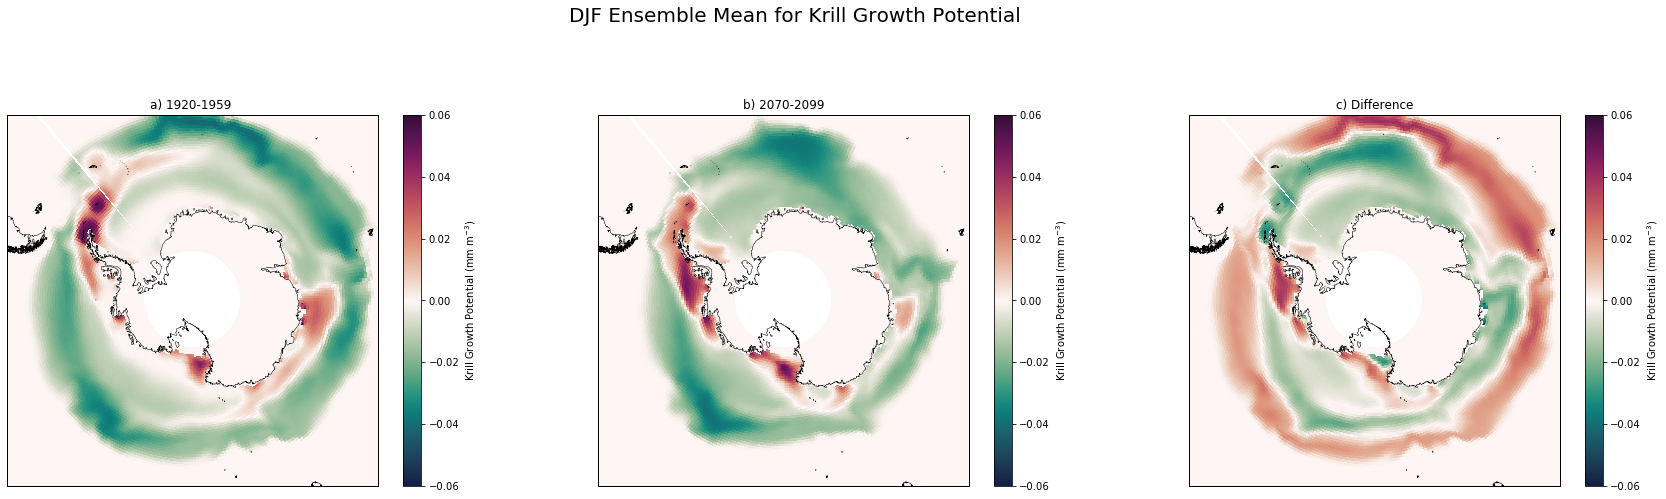

In [19]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(30,15))
fig.suptitle('DJF Ensemble Mean for Krill Growth Potential', fontsize=20)

#---------- KGP
ax = fig.add_subplot(2,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) 1920-1959 ')

pc=ax.pcolormesh(lon, lat, kgp_early, cmap='cmo.curl',
                 vmin = -.06, vmax = .06,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Krill Growth Potential (mm m$^{-3}$)')

#----------SST
ax = fig.add_subplot(2,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) 2070-2099')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, kgp_late, cmap='cmo.curl',
                 vmin = -.06, vmax = .06,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Krill Growth Potential (mm m$^{-3}$)')

#----------Chl
ax = fig.add_subplot(2,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) Difference')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, kgp_diff, cmap='cmo.curl',
                 vmin = -.06, vmax = .06,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Krill Growth Potential (mm m$^{-3}$)')

#fig.savefig('KGP epoch and difference', bbox_inches='tight') #,format='pdf');


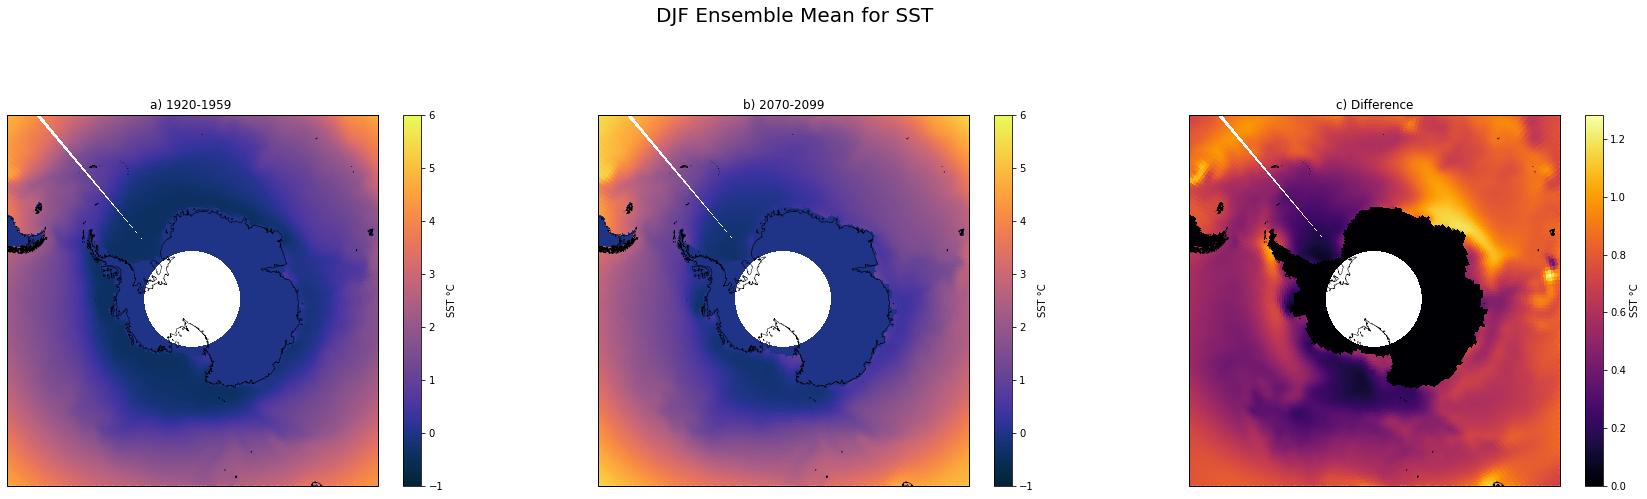

In [20]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(30,15))
fig.suptitle('DJF Ensemble Mean for SST', fontsize=20)

#---------- KGP
ax = fig.add_subplot(2,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) 1920-1959 ')

pc=ax.pcolormesh(lon, lat, sst_early, cmap='cmo.thermal',
                 vmin = -1, vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='SST °C')

#----------SST
ax = fig.add_subplot(2,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) 2070-2099')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, sst_late, cmap='cmo.thermal',
                 vmin = -1, vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='SST °C')

#----------Chl
ax = fig.add_subplot(2,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) Difference')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, sst_diff, cmap='inferno',
                 #vmin = -1, vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='SST °C')

fig.savefig('SST epoch and difference', bbox_inches='tight') #,format='pdf');


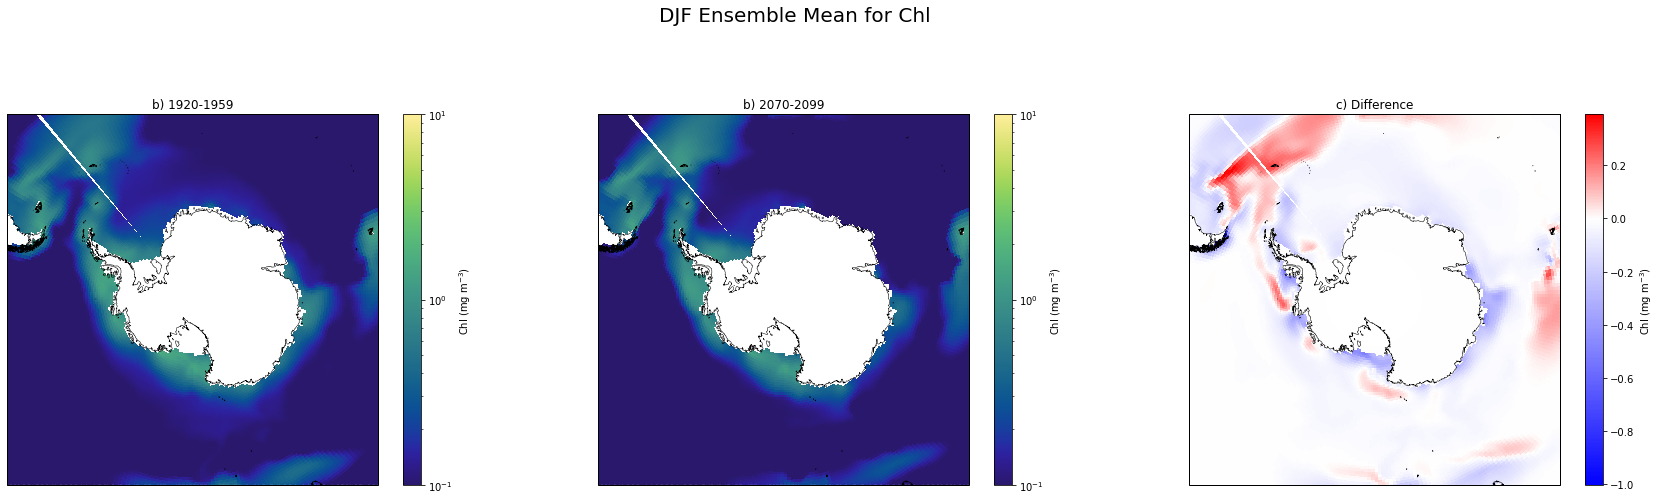

In [21]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(30,15))
fig.suptitle('DJF Ensemble Mean for Chl', fontsize=20)

#---------- KGP
ax = fig.add_subplot(2,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('b) 1920-1959')
norm = colors.LogNorm(vmin=0.1, vmax=10.)

pc=ax.pcolormesh(lon, lat, chl_early, cmap=cmocean.cm.haline,
                 norm=norm,
                 transform=ccrs.PlateCarree())
cbar3 = fig.colorbar(pc, ax=ax,label='Chl (mg m$^{-3}$)')

#----------SST
ax = fig.add_subplot(2,3,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('b) 2070-2099')
norm = colors.LogNorm(vmin=0.1, vmax=10.)

pc=ax.pcolormesh(lon, lat, chl_late, cmap=cmocean.cm.haline,
                 norm=norm,
                 transform=ccrs.PlateCarree())
cbar3 = fig.colorbar(pc, ax=ax,label='Chl (mg m$^{-3}$)')

#----------Chl
ax = fig.add_subplot(2,3,3, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('c) Difference')

pc=ax.pcolormesh(lon, lat, chl_diff, cmap='bwr', norm=MidpointNormalize(midpoint=0.),
                 transform=ccrs.PlateCarree())
cbar3 = fig.colorbar(pc, ax=ax,label='Chl (mg m$^{-3}$)')

fig.savefig('Chl epoch and difference-normalized', bbox_inches='tight') #,format='pdf');


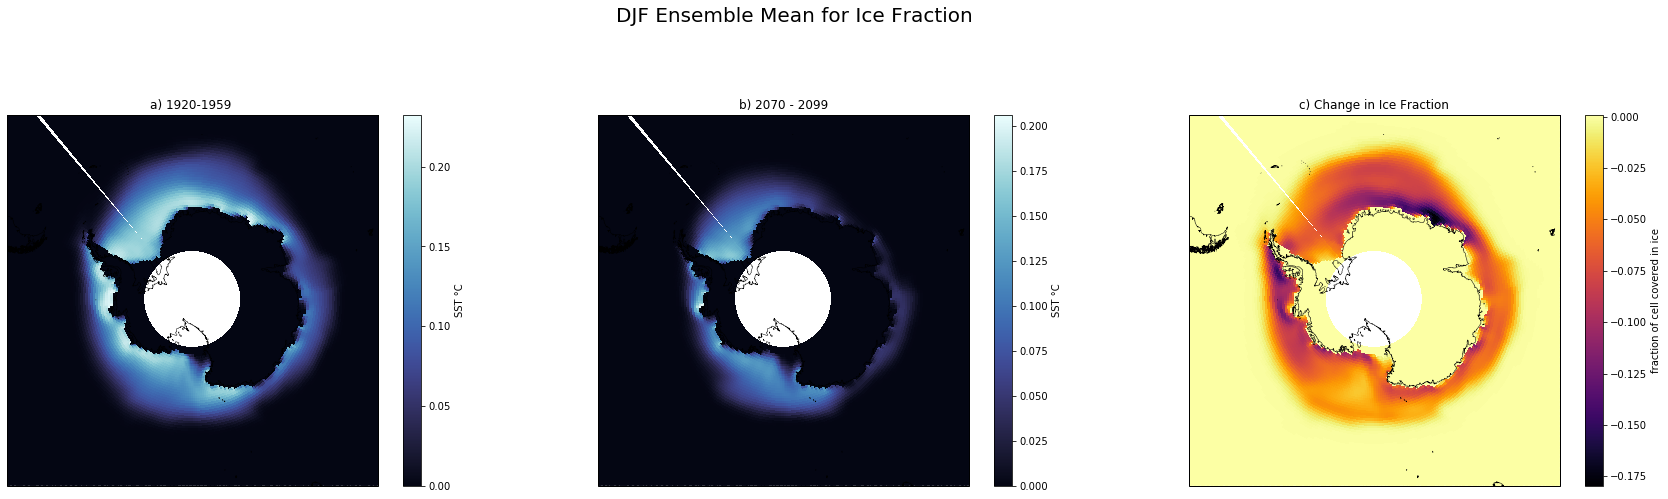

In [22]:

fig = plt.figure(figsize=(30,15))
fig.suptitle('DJF Ensemble Mean for Ice Fraction', fontsize=20)

#---------- KGP
ax = fig.add_subplot(2,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) 1920-1959 ')

pc=ax.pcolormesh(lon, lat, ice_early, cmap='cmo.ice',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='SST °C')

#----------SST
ax = fig.add_subplot(2,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) 2070 - 2099')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, ice_late, cmap='cmo.ice',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='SST °C')

#----------Chl
ax = fig.add_subplot(2,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) Change in Ice Fraction')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, ice_diff, cmap='inferno',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='fraction of cell covered in ice')

fig.savefig('Ice epoch and difference', bbox_inches='tight') #,format='pdf');


In [79]:
ds_djf_epoch

<xarray.Dataset>
Dimensions:    (epoch: 2, length: 3, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch      (epoch) <U9 '1920-1950' '2070-2100'
  * length     (length) float64 20.0 40.0 60.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * z_t        (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf   (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC      (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP        (epoch, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 17, 47, 160), meta=np.ndarray>
    SST        (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>

In [ ]:
#PLOT IT
dsp = util.pop_add_cyclic(ds_djf_epoch)

lon, lat = dsp.TLONG.isel(nlat=slice(0, 100)), dsp.TLAT.isel(nlat=slice(0, 100)) 
field = dsp.Chl_surf.isel(month=0, nlat=slice(0, 100))
#field = np.log(dsp.Chl_surf.isel(month=0, nlat=slice(0, 100)))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cmap = cmocean.cm.haline
levels = np.logspace(-2, 1, 16)
norm = colors.LogNorm(vmin=0.01, vmax=20.)

cf = ax.contourf(lon, lat, field,
                 levels=levels,
                 cmap=cmap,
                 extend='both',
                 norm=norm,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder
#plt.title('January Model Output np.log ')
plt.title('January: Model 1986 - 2005')

#plt.title('January Model Output')
fig.colorbar(cf, ax=ax)
#plt.savefig('January-CESM-Chl-map.png')

___
## Temporal Variance

In [26]:
#for saving figures:
pwd = os.getcwd()
pwd
os.chdir('/glade/u/home/zephyrs/projects/krill-cesm-le/notebooks')
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/notebooks'

In [27]:
#load data
ds_djf = xr.open_zarr('data/cesm-le-fields-djf-regional-timeseries.zarr')